In [1]:
# !pip install bertopic llama-cpp-python sentence-transformers umap-learn hdbscan datamapplot

import os
import pickle

import torch
import numpy as np
import pandas as pd
import nltk

from huggingface_hub import hf_hub_download
from pathlib import Path
from llama_cpp import Llama
from bertopic.representation import KeyBERTInspired, LlamaCPP
from sentence_transformers import SentenceTransformer
from umap import UMAP
from hdbscan import HDBSCAN
from bertopic import BERTopic
import datamapplot





#for japanese fonts in  plots
import matplotlib.pyplot as plt
plt.rcParams["font.family"] = "Noto Sans CJK JP"
plt.rcParams["axes.unicode_minus"] = False

# Detect device: Apple MPS if available, else CPU
device = "mps" if torch.backends.mps.is_available() else "cpu"
print("Using device:", device)

# One‐time NLTK download
nltk.download("stopwords", quiet=True)


#Upload japanese processor and topic modeler (defined manuallt in multiling_helpers.py)
import sys
script_dir = os.path.dirname(os.path.abspath('__file__'))
print("Script directory:", script_dir)
multilingual_dir = os.path.join(script_dir, 'MULTILINGUAL')
sys.path.append(multilingual_dir)
print(f"Added {multilingual_dir} to Python path")
from multiling_helpers import JapaneseProcessor, TopicModeler

#initialise japanese processor
japanese_processor = JapaneseProcessor()
japanese_processor.sentence_transformer_model = "sonoisa/sentence-bert-base-ja-mean-tokens"#"paraphrase-multilingual-mpnet-base-v2"#"sonoisa/sentence-bert-base-ja-mean-tokens" #"oshizo/sbert-jsnli-luke-japanese-base-lite" #"sonoisa/sentence-bert-base-ja-mean-tokens" #cl-tohoku/bert-base-japanese-v3




Using device: mps
Script directory: /Users/rbeaute/Projects/MOSAIC
Added /Users/rbeaute/Projects/MOSAIC/MULTILINGUAL to Python path


### download and configure Japanese Llama 3 (Eliza)

https://huggingface.co/elyza/Llama-3-ELYZA-JP-8B-GGUF


In [2]:

# ── CONFIG ──
repo_id   = "elyza/Llama-3-ELYZA-JP-8B-GGUF"
filename  = "Llama-3-ELYZA-JP-8B-q4_k_m.gguf"
cache_dir = "/Users/rbeaute/Projects/MOSAIC/MULTILINGUAL/models/elyza_Llama-3-ELYZA-JP-8B"
os.makedirs(cache_dir, exist_ok=True)

# ── DOWNLOAD ──
model_path = hf_hub_download(
    repo_id=repo_id,
    filename=filename,
    cache_dir=cache_dir,
    repo_type="model",
    force_filename=filename
)
print("Quantized GGUF model saved to:", model_path)


Quantized GGUF model saved to: /Users/rbeaute/Projects/MOSAIC/MULTILINGUAL/models/elyza_Llama-3-ELYZA-JP-8B/models--elyza--Llama-3-ELYZA-JP-8B-GGUF/snapshots/4367e810791b8f647b1cb14452ec390654ad9ef9/Llama-3-ELYZA-JP-8B-q4_k_m.gguf


### Load innerspeech dataset

In [3]:
local_pkl = "/Users/rbeaute/Projects/MOSAIC/DATA/multilingual/japanese/innerspeech/innerspeech_reports.pkl"

with open(local_pkl, "rb") as f:
    raw_reports = pickle.load(f)

print("Raw reports type:", type(raw_reports))
if hasattr(raw_reports, "head"):
    display(raw_reports.head(3))
    docs = raw_reports["text"].astype(str).tolist()  
else:
    docs = [str(x) for x in raw_reports]
    print("Sample docs:", docs[:3])

print(f"Total documents: {len(docs)}")


Raw reports type: <class 'list'>
Sample docs: ['頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。', '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）', '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。\n映像や味などは思い出される事がある。']
Total documents: 731


### Preprocess dataset

In [5]:
cleaned_docs = [japanese_processor.preprocess_text(d) for d in docs] #super basic preprocessing (remove extra spaces, etc)
sentences, doc_map = japanese_processor.split_sentences(cleaned_docs)
print(f"Split into {len(sentences)} sentences from {len(cleaned_docs)} docs")

print("First 3 raw doc:", docs[:3])
# print("First 5 cleaned docs:", cleaned_docs[:10])
print("First 5 sentences:", sentences[:5])
print("doc_map for those 5 sentences:", doc_map[:5])


Split into 1846 sentences from 731 docs
First 3 raw doc: ['頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。', '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）', '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。\n映像や味などは思い出される事がある。']
First 5 sentences: ['頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。', '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？', '（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）', '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。', '映像や味などは思い出される事がある。']
doc_map for those 5 sentences: [0, 1, 1, 2, 2]


In [6]:
import pandas as pd

sample_df = pd.DataFrame({
    "raw": docs[:5],
    "cleaned": cleaned_docs[:5]
})
print(sample_df.to_markdown())

for i, sent in enumerate(sentences[:5]):
    print(f"{i:02d}:", sent)


|    | raw                                                                                                                                                                                                                                                                                                               | cleaned                                                                                                                                                                                                                                                                                                                                                                                         |
|---:|:----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

In [15]:
print("RAW docs[0]:", repr(docs[0]))
print("CLEANED docs[0]:", repr(cleaned_docs[0]))
for i, sent in enumerate(sentences[:5]):
    print(f"  sentence[{i}]:", repr(sent))


RAW docs[0]: '頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。'
CLEANED docs[0]: '頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。'
  sentence[0]: '頭の中の独り言をこのような調査で改めて自覚することができ、また色々なパターンがあることを知り面白かった。'
  sentence[1]: '他人の声が脳内でしている人がいるという話にすごく興味があるのですが、心理物理実験で音声のパラメータチューニングかA/Bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね？'
  sentence[2]: '（具現化しようとした途端に霞をつかむようにとらえどころのないものになってしまうなどの可能性もあるかもなあと思いつつ）'
  sentence[3]: '頭の中では日本語で考えているという自覚はある（英語は勉強以外にほぼ使ったことはない）が、文字か音声かと言われると、どちらも混ざっている感じがする。'
  sentence[4]: '映像や味などは思い出される事がある。'


###  Instantiate LLM & embedding model

In [8]:
# Quantized Llama-3 (runs on CPU; no CUDA)
llm = Llama(
    model_path=model_path,
    n_ctx=4096,
    n_gpu_layers=-1,
    stop=["Q:", "\n"],
    verbose=False
)

# Sentence-Transformer on MPS/CPU
embed_model = SentenceTransformer(
    japanese_processor.sentence_transformer_model,
    device=device
)

llama_init_from_model: n_ctx_per_seq (4096) < n_ctx_train (8192) -- the full capacity of the model will not be utilized
ggml_metal_init: skipping kernel_get_rows_bf16                     (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_1row              (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_f32_l4                (not supported)
ggml_metal_init: skipping kernel_mul_mv_bf16_bf16                  (not supported)
ggml_metal_init: skipping kernel_mul_mv_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_mul_mm_bf16_f32                   (not supported)
ggml_metal_init: skipping kernel_mul_mm_id_bf16_f32                (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h64           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf16_h80           (not supported)
ggml_metal_init: skipping kernel_flash_attn_ext_bf

### Compute Embeddings & 2D Viz Coordinates

In [9]:
embeddings = embed_model.encode(sentences, show_progress_bar=True)
print("Embeddings shape:", embeddings.shape)

viz_embeddings = UMAP(
    n_neighbors=10,
    n_components=2,
    min_dist=0.5,
    metric="cosine",
    random_state=42
).fit_transform(embeddings)


Batches:   0%|          | 0/58 [00:00<?, ?it/s]

Embeddings shape: (1846, 768)


### Define UMAP/HDBSCAN & Representation Models

In [11]:
umap_model = UMAP(
    n_neighbors=15,
    n_components=10,
    min_dist=0.01, # > 0 to avoid overfitting and avoid collapsing points too tightly
    metric="cosine",
    random_state=42
)
hdbscan_model = HDBSCAN(
    min_cluster_size=10, #allow to form topics out of 10 sentences
    min_samples=5, 
    metric="euclidean",
    cluster_selection_epsilon=0.1, #help merge closer clusters
    prediction_data=True
)



# prompt = """
# Q:  
# トピックのキーワード: [KEYWORDS]  
# トピックのドキュメント: [DOCUMENTS]  

# 以下の条件を満たす科学的なラベルを生成してください:  
# 1. **タイトルケース**（例: 「Adhd 診断 併存」）  
# 2. **2～4語以内**（名詞のみ、動詞・形容詞は不可）  
# 3. キーワード/ドキュメントの**明示的な用語のみ反映**（解釈や抽象表現は禁止）  
# 4. 句読点、例文、説明文は一切含まない  

# A:  
# """


prompt = """
Q:
以下の情報をもとに、科学的な「トピックラベル」を生成してください。

――――――

サンプル:
トピックのキーワード: [「内言」「映像」「味」]
トピックのドキュメント: 
「頭の中では日本語で考えているとき、文字か音声かではなく映像や味も感じることがある。」

生成ラベル: 「内言 感覚結合」

――――――

本番:
トピックのキーワード: [KEYWORDS]
トピックのドキュメント: [DOCUMENTS]

以下の条件を満たす科学的なラベルを生成してください:
1. タイトルケース（例: 「Adhd 診断 併存」）
2. 2～4語以内（名詞のみ、動詞・形容詞は不可）
3. キーワード/ドキュメントの明示的な用語のみ反映（解釈や抽象表現は禁止）
4. 句読点、例文、説明文は一切含まない

A:
"""

pipeline_kwargs = {
    "max_tokens": 6,               # ラベル長を制限（4語 + 余白）
    "temperature": 0.1,            # 低ランダム性（キーワード厳守）
    "top_p": 0.6,                  # 高確率トークンのみサンプリング
    "repeat_penalty": 1.2,         # 単語繰り返しを軽減
    "stop": ["\n", "。", "、"]     # 1行のみ出力
}

# representation_model = {
#     "KeyBERT": KeyBERTInspired(),
#     "LLM-JP": LlamaCPP(llm, prompt=prompt)
# }


representation_model = {
   "KeyBERT": KeyBERTInspired(),
   "LLM": LlamaCPP(llm, prompt=prompt,nr_docs=10, #show 10 sentences per topic
                   pipeline_kwargs=pipeline_kwargs,diversity=0.2)
}

In [20]:
list(japanese_processor.stopwords)

['ました',
 '恐縮',
 '失礼いたしました',
 'は',
 '参考になりました',
 '恐れ入ります',
 '論文',
 '調査',
 '成功',
 '研究',
 'が',
 '回答',
 'よろしく',
 '期待してます',
 'お手数',
 'ありがとう',
 'も',
 '素晴らしい',
 'させていただきます',
 'です',
 'ありがとうございます',
 '申し訳ありません',
 'ご容赦',
 'アンケート',
 'お邪魔します',
 'へ',
 '楽しかった',
 'で',
 'に',
 '分析',
 '質問',
 '失礼します',
 'ます',
 '成果',
 'ございます',
 'を',
 'と',
 '面白い',
 '興味深い',
 '応援してます',
 '感謝',
 'くださいまして',
 'すみません',
 '勉強になりました',
 '頑張ってください',
 '実験',
 'お願いします',
 'ありがとうございました']

### Fit Bertopic

In [ ]:
# check what a vectoriser would do 
temp_vectorizer = CountVectorizer(
    ngram_range=(1,2),
    stop_words=list(japanese_processor.stopwords),    # no stopwords
    max_df=0.85
)
temp_vectorizer.fit(sentences)
print("Temp vocabulary size :", len(temp_vectorizer.vocabulary_))
print("Sample words :", list(temp_vectorizer.vocabulary_.keys())[:20])


Temp vocabulary size : 13
Sample words : ['内言', 'また', 'ただ', 'なので', '自分の声', '私の場合', '面白かったです', '映像', 'ありがとうございました', '例えば', 'しかし', 'と思いました', 'など']


In [24]:
from sklearn.feature_extraction.text import CountVectorizer

topic_model = BERTopic(
    embedding_model=embed_model,
    umap_model=umap_model,
    hdbscan_model=hdbscan_model,
    representation_model=representation_model,
    # vectorizer_model=CountVectorizer(
    #     ngram_range=(1,2),  # bigrams 
    #     stop_words=list(japanese_processor.stopwords),
    #     max_df=0.85, #lower to drop excessively common words
    #     min_df=2), #avoid gettinh topics on very rare words
    language="japanese",
    top_n_words=10,
    nr_topics="auto", #automatically reduce number of topics by merging similar ones
    verbose=True
)


topics, probs = topic_model.fit_transform(sentences, embeddings)
print("Number of topics:", len(set(topics)) - (1 if -1 in topics else 0))


2025-06-03 19:12:49,303 - BERTopic - Dimensionality - Fitting the dimensionality reduction algorithm
2025-06-03 19:12:53,992 - BERTopic - Dimensionality - Completed ✓
2025-06-03 19:12:53,993 - BERTopic - Cluster - Start clustering the reduced embeddings
2025-06-03 19:12:54,040 - BERTopic - Cluster - Completed ✓
2025-06-03 19:12:54,041 - BERTopic - Representation - Extracting topics from clusters using representation models.
100%|██████████| 40/40 [02:30<00:00,  3.75s/it]
2025-06-03 19:15:32,958 - BERTopic - Representation - Completed ✓
2025-06-03 19:15:32,960 - BERTopic - Topic reduction - Reducing number of topics
100%|██████████| 36/36 [02:11<00:00,  3.65s/it]
2025-06-03 19:17:50,676 - BERTopic - Topic reduction - Reduced number of topics from 40 to 36


Number of topics: 35


In [25]:
#print raw labels exytavyed by LLama

raw_llm_labels = [label[0][0] for label in topic_model.get_topics(full=True)["LLM"].values()]
print(raw_llm_labels)

llm_labels = raw_llm_labels.copy()

['生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「映', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「思考', '生成ラベル: 「内', '生成したトピックラ', '生成したトピックラ', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成したトピックラ', '生成ラベル: 「共', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成したトピックラ', '生成したトピックラ', '生成ラベル: 「内', '生成ラベル: 「内', '生成したトピックラ', '生成ラベル: 「アン', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成ラベル: 「内', '生成したトピックラ']


In [28]:
# if need more cleaning (as we did for english), can use:

# import re 

# llm_labels = [label[0][0].replace('\nThe topic is labeled as:','').replace('\n', '').replace('Label:', '').replace('"', '') for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels
# llm_labels = [re.sub(r'\W+', ' ', label[0][0].split("\n")[0].replace('"', '')) for label in topic_model.get_topics(full=True)["LLM"].values()]
# llm_labels = [label if label else "Unlabelled" for label in llm_labels]
# all_labels = [llm_labels[topic+topic_model._outliers] if topic != -1 else "Unlabelled" for topic in topics] 

# filtered_labels = [label for label in all_labels if label != "Unlabelled"] #remove -1 topics (outliers)

# llm_labels

### Visualise topics

In [29]:
#get the summary table of all topics (including the ‘–1’ outliers)
info = topic_model.get_topic_info()
display(info)

# build a map from topic ID to label 
name_map = dict(zip(info.Topic, info.Name))

# for each document look its label
bertopic_labels = [ name_map[t] for t in topics ]
np.unique(bertopic_labels, return_counts=True)

,Topic,Count,Name,Representation,KeyBERT,LLM,Representative_Docs
0,-1,750,-1_内言_また_自分の声_なので,"[内言, また, 自分の声, なので, ただ, など, 映像, とか, そのため, たとえば]",[数々のシステム開発を成功させている人間は内言のモデルを考える時に非常に重要な事例となるはず...,"[生成ラベル: 「内, , , , , , , , , ]",[物事について考えたり、アイデアを出す時は聴覚優位（自分の声、自分と別人格との会話）の内言に...
1,0,140,0_この文章を書いている最中も_映像_文章で考えている_書きながら組み立てていくのが多い,"[この文章を書いている最中も, 映像, 文章で考えている, 書きながら組み立てていくのが多い...","[文章を書いている時も必ず内言が生じていることに気づきました, 書くべき文の内容を思い起こし...","[生成ラベル: 「内, , , , , , , , , ]",[この文章を書いている最中も、どのような文章を書こうか考えているわけではなく、内容とは関連性...
2,1,137,1_感覚_しかし_360度カメラとか極座標っぽい空間認識_概ね静止画だが細かく思い出す時は映像,"[感覚, しかし, 360度カメラとか極座標っぽい空間認識, 概ね静止画だが細かく思い出す時...","[探しもののような具体的なイメージが必要な場合は映像と音声で, 私は日常的な思考は頭の中のも...","[生成ラベル: 「内, , , , , , , , , ]",[僕の場合もまさにそうで、特に自分の声で思考したり、自分がこれまでに見た映像や音で回想したり...
3,2,92,2_ただ_bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね_発言は...,"[ただ, bテストかを繰り返すことでその人の脳内の声を具現化することってできますかね, 発言...","[場面をイメージしながら1人で自分と声に出して会話をするのが一番考えがまとまる, 相手と話す...","[生成ラベル: 「内, , , , , , , , , ]",[内言において自分以外の特定の他者（家族、友人、恩師等様々な人）が登場し話すことがあるが、自...
4,3,83,3_内言の声は_また_1人で過ごす時_普通の人が言葉で話すように,"[内言の声は, また, 1人で過ごす時, 普通の人が言葉で話すように, 基本的に思考する時は...","[自分の地声とは確かに違うけど確かに自分の声と感じる不思議な声です, 自分の声の自分と自分の...","[生成ラベル: 「内, , , , , , , , , ]",[また、内言の声色は分からないので今の自分の声か、他人の声か、もし声変わりしていたらの自分の...
5,4,62,4_あなたはどう考えた_基本的には場面によって使い分ける感覚はありますが_言われてみればこう...,"[あなたはどう考えた, 基本的には場面によって使い分ける感覚はありますが, 言われてみればこ...",[考えてるのを言語化してもこの事の次にこれ挟んでこの事の次に謝罪でいっかくらいにしかなりませ...,"[生成ラベル: 「内, , , , , , , , , ]","[言葉で考えられることと言葉で考えられないこと(図形など)で思考方法が異なります。, を使っ..."
6,5,57,5_写真_食べたいもの_対して_映像,"[写真, 食べたいもの, 対して, 映像, 例えば, しかし, 私の感情がそれを気に入った時...","[気に入らなかった場合は次の食べ物の映像と味が想像されて, 食べたいもののような身体に問う思...","[生成ラベル: 「映, , , , , , , , , ]",[日常で「食べたいもの」を考える時は、頭の中で食べ物の映像と味が想像され、私の感情がそれを気...
7,6,49,6_20歳頃までは物凄く内言が多かったが_発達障害のasd診断済みだがadhdの特性もあるた...,"[20歳頃までは物凄く内言が多かったが, 発達障害のasd診断済みだがadhdの特性もあるた...",[言語空間上で思考するというプロセスだけに着目すると脳内の処理に大した違いはないのではないと...,"[生成ラベル: 「内, , , , , , , , , ]",[将棋棋士の藤井聡太さんは、一般的な棋士が読みで頭に浮かべる盤面予想(頭の中で駒を動かす)で...
8,7,38,7_ずっとぶつぶつ独り言を言うことも多いです_頭の中で他者の声で常に独り言を言っているような...,"[ずっとぶつぶつ独り言を言うことも多いです, 頭の中で他者の声で常に独り言を言っているような...","[内言して思考するより独り言を呟きながら作業してしまう, 内言は基本的に独り言ですが重要な決...","[生成ラベル: 「内, , , , , , , , , ]",[（主に）一人でいるときは、内言をすべて口に出して、ずっとぶつぶつ独り言を言うことも多いです...
9,8,35,8_10代から30代中頃まで離人症_飲む以前は_身体動作の内言_音声が一番近いけれど結構もや...,"[10代から30代中頃まで離人症, 飲む以前は, 身体動作の内言, 音声が一番近いけれど結構...","[頭の中に自分の声での思考と映像のイメージがとめどなく流れているような感じでしたが, 内言の...","[生成ラベル: 「内, , , , , , , , , ]",[「通りがいい」「筋がいい」という言葉があるように、「抜けやすさ」をもとに試行していることが...


(array(['-1_内言_また_自分の声_なので',
        '0_この文章を書いている最中も_映像_文章で考えている_書きながら組み立てていくのが多い',
        '10_4次元程度の空間で思考を行っていた_対象が時間的に連続な場合や_日本史の_複合的な現象の変数間の関係をモデル化しようとするときとかは',
        '11_頭が冴えているときはよく出来るが_でもそんなんしたらお金なくなるしあかんわ_貴重なお時間ありがとうございました_結果がとても気になります',
        '12_内言_いろいろなタイプの_環境や思考するテーマによって_シチュエーションによって内言が変わるような気もしました',
        '13_ありがとうございました_cqcq_fb21_難しいです',
        '14_楽しかったです_回答していて楽しかったです_結果が知りたいです_結果が気になる',
        '15_ああかな_動画によるバイアスが少なくなるかもしれないと思いました_自分一人で内省しているようなときはまた異なる内言の現れ方をするのではないかと思います_脳内で文字起こしされるの手順を踏むことが多く',
        '16_これまで無意識でしたが面白かったです_逆に誰も居なくて無の時もある_声がしないときもある_声がカブることは無い',
        '17_内言と理解力に関係はあるのか知りたいです_内言が多く_論理的な思考を要さないときなどは_自分にとって内言はもう一人の自分みたいなものであり',
        '18_大変面白い調査だと思います_暗ければ黒いモヤのフレームが付いている気がします_学際的興味を惹かれる大変面白い研究だと思う_頭の中で物事によって理解方法が異なるとは考えもしなかったので面白い気づきになりました',
        '19_という感覚もあります_ぼやっとした中から突然形になって出てくる_ときどきうるさく感じる_モヤモヤしています',
        '1_感覚_しかし_360度カメラとか極座標っぽい空間認識_概ね静止画だが細かく思い出す時は映像',
        '20_あるいは聞こえても言葉として認識できなかった声は字幕表記されません_あるいは複数人の言葉が交わる事が多々あり_褒められたり

In [30]:
import importlib
import datamapplot

# force reload so create_plot is back to its original
datamapplot = importlib.reload(datamapplot)

_orig_create = datamapplot.create_plot


from matplotlib.text import Text, Annotation

def create_jp_plot(*args, font="Hiragino Sans", **kwargs):
    # draw with the genuine original
    fig, ax = _orig_create(*args, **kwargs)
    # patch every Text and Annotation
    for art in fig.findobj(match=lambda o: isinstance(o, (Text, Annotation))):
        try:
            art.set_fontname(font)
        except Exception:
            pass
    return fig, ax

datamapplot.create_plot = create_jp_plot



In [31]:
len(llm_labels)

36

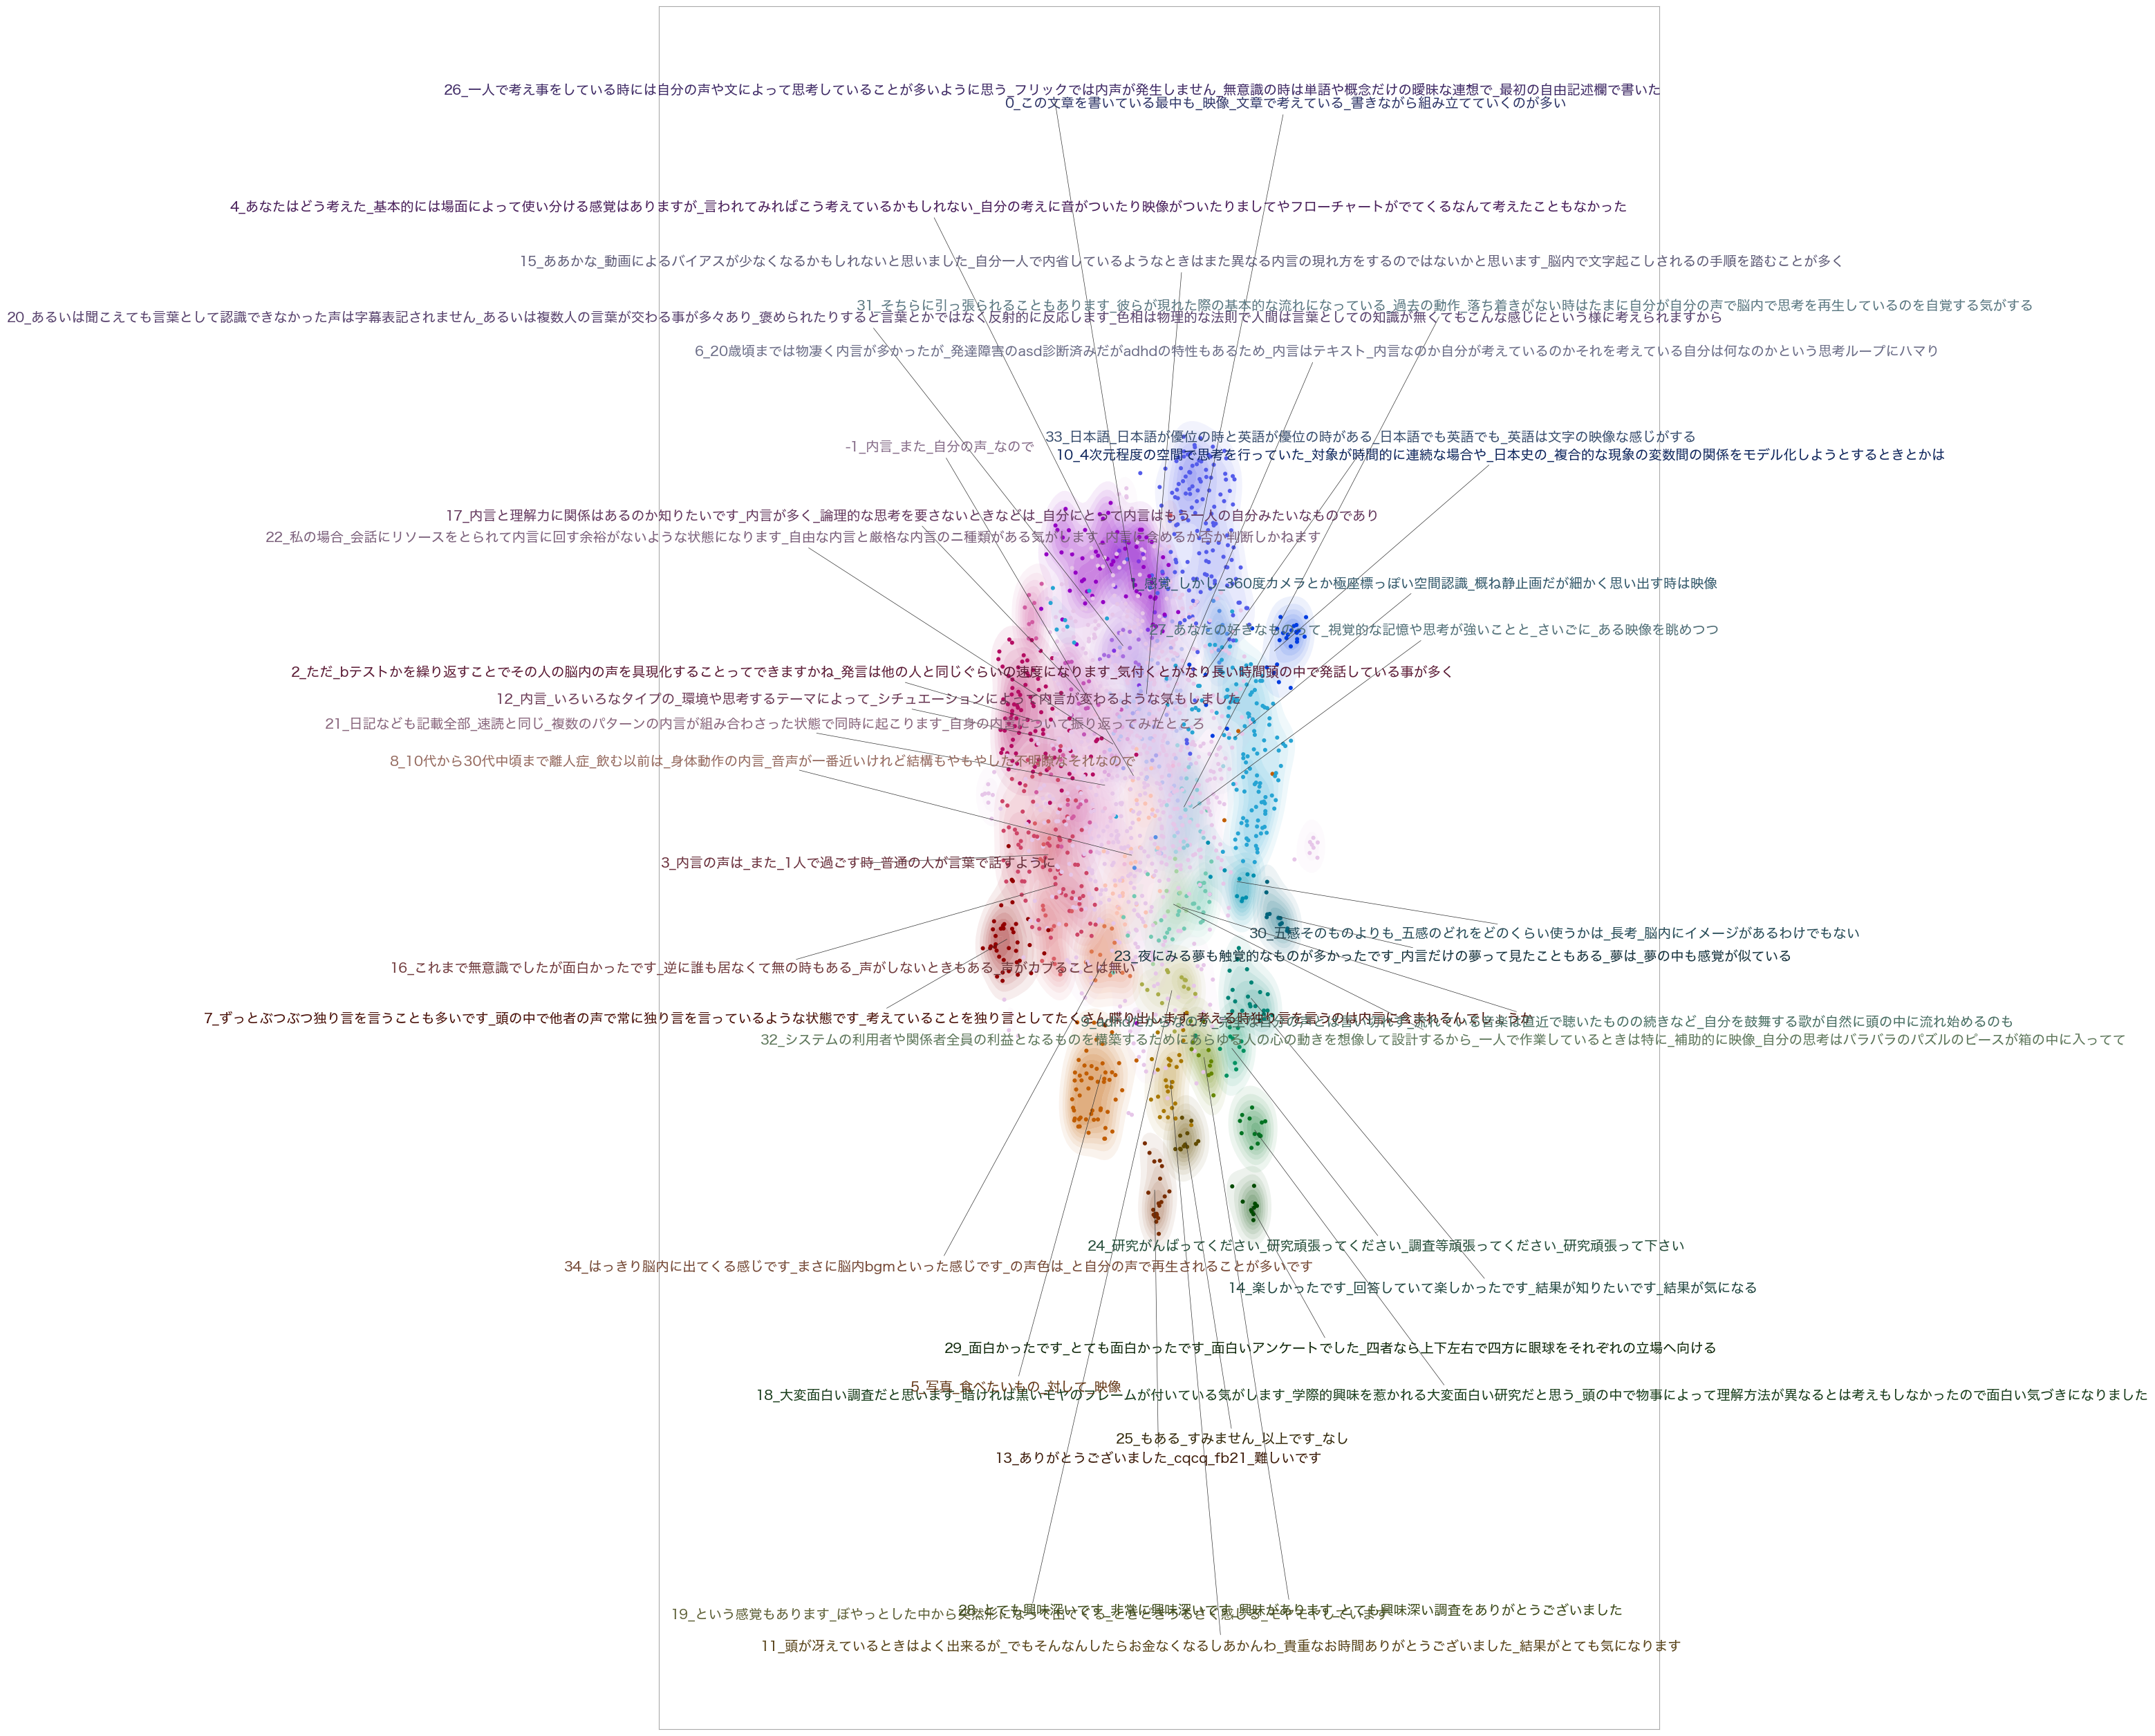

In [32]:
fig, ax = datamapplot.create_plot(
    viz_embeddings,
    bertopic_labels,
    label_font_size=14,
    # title="Japanese BERTopic (Llama-3-ELYZA-JP-8B)",
    # sub_title="Labels by quantized Llama-3-ELYZA",
    label_wrap_width=15,
    use_medoids=False,
    figsize=(30, 25)
)


plt.show()
